In [1]:
from numpy import nan
import pickle
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt


In [2]:
storage_path = r"/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/"
intensity_model_path = storage_path + r"15-12-2022-actin_intensity local dens-False, s%s, s%s train [130, 160] diff window win size 16/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_/" % (1,5)
motility_model_path = storage_path + r"15-12-2022-motility local dens-False, s%s, s%s train [130, 160] diff window/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_/" % (1,5)

"DMSO"
s2_path_actin_intensity= intensity_model_path + 'df_score_vid_num_S2.pkl'
s2_path_motility=motility_model_path + 'df_score_vid_num_S2.pkl'

"ERKi"
s3_path_actin_intensity=intensity_model_path + 'df_score_vid_num_S3.pkl'
s3_path_motility= motility_model_path + 'df_score_vid_num_S3.pkl'

"ERKi-P38i"
s6_path_actin_intensity= intensity_model_path + 'df_score_vid_num_S6.pkl'
s6_path_motility=motility_model_path + 'df_score_vid_num_S6.pkl'

"P38i"
s8_path_actin_intensity=intensity_model_path + 'df_score_vid_num_S8.pkl'
s8_path_motility= motility_model_path + 'df_score_vid_num_S8.pkl'

dictoni_score = {'s6_path_actin_intensity': s6_path_actin_intensity,
               's8_path_actin_intensity': s8_path_actin_intensity,
                's2_path_actin_intensity': s2_path_actin_intensity,
                's3_path_actin_intensity': s3_path_actin_intensity,
                's6_path_motility': s6_path_motility, 
                's8_path_motility': s8_path_motility,
                's2_path_motility': s2_path_motility,
                's3_path_motility': s3_path_motility,
               }


# T-test between trajectory #

In [4]:

def check_significant_results(df_1, df_2, significant_level, modality):
    print(f"modality: {modality}")
    # Perform t-test between consecutive columns
    p_values = []
    mean_list = []
    counter=0
    empty_num=0
    frame_list=[]
    for i in range(29, 256):
        column_i_1 = df_1[i].dropna()
        column_i_2 = df_2[i].dropna()
        
        
        
        if (column_i_1.empty or column_i_2.empty):
            empty_num=empty_num+1
            continue
        counter=counter+1

        df_2_mean=column_i_2.mean()
        mean_list.append(df_2_mean)


        _, p_value = stats.ttest_ind(column_i_2, column_i_1, alternative='greater')

        p_values.append(p_value)
        frame_list.append(i)
    time_list=[(time*5)/60 for time in range(29,256)] 
    # Create a DataFrame to display the p-values
    result_df = pd.DataFrame({'p-value': p_values, 'frame': frame_list, 'time': time_list, 'mean': mean_list})

    # Filter the results where the average of column i+1 is greater than column i
    significant_results = result_df[result_df['p-value'] <= significant_level]

    
    return result_df, significant_results


In [5]:
def create_significant_results(vid_num1, vid_num2, significant_level, modality):
    
    if modality == 'motility':
        with open(dictoni_score[f"s{vid_num1}_path_motility"], 'rb') as f:
            df_s1 = pickle.load(f)
         
        with open(dictoni_score[f"s{vid_num2}_path_motility"], 'rb') as f:
            df_s2 = pickle.load(f)
            
    else:
        with open(dictoni_score[f"s{vid_num1}_path_actin_intensity"], 'rb') as f:
            df_s1 = pickle.load(f)

        with open(dictoni_score[f"s{vid_num2}_path_actin_intensity"], 'rb') as f:
            df_s2 = pickle.load(f)
    
    all_results, significant_results = check_significant_results(df_s1, df_s2, significant_level, modality)
    return df_s2, all_results, significant_results

In [6]:

def preprocess_p_value_df(significant_results_df, start_frame, final_frame, original_diff_df):
    p_value_list=[]
    not_p_value=[]
    s3_mean_list=[]

    for i in range(start_frame, final_frame): 
        if i in significant_results_df['frame'].to_list():
            p_value_list.append('yes')
        else:
            p_value_list.append('no')

        column_i_s3 = original_diff_df[i]
        s3_mean=column_i_s3.mean()
        s3_mean_list.append(s3_mean)
    time_list=[(time*5)/60 for time in range(start_frame,final_frame)] 

    p_value_df = pd.DataFrame({'s3_mean': s3_mean_list, 'p-value_sign': p_value_list, 'time': time_list, 'frame': range(start_frame, final_frame)})
    return p_value_df

In [7]:

def plot_t_test_results(p_value_df, significant_level, modality, x_label, y_label):
    # Create a color map dictionary
    color_map = {'yes': 'green', 'no': 'red'}

    # Extract the necessary data for plotting
    x = p_value_df['time']
    y = p_value_df['s3_mean']
    colors = p_value_df['p-value_sign'].map(color_map)

    # Set dot size
    dot_size = 10  # Adjust the value as needed

    # Plotting
    plt.scatter(x, y, s=dot_size, c=colors)

    # Set y-axis limits
    plt.ylim(0, 1)
    plt.xlim(0, 23)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'T-Test hypotheses about the control group and the experimental group-differentiated- {modality}')

    # Create legend
    green_patch = plt.Line2D([], [], color='green', marker='o', linestyle='None',
                             markersize=8, label=f"p-value <= {significant_level}")
    red_patch = plt.Line2D([], [], color='red', marker='o', linestyle='None',
                           markersize=8, label=f"p-value > {significant_level}")
    plt.legend(handles=[green_patch, red_patch])

    # Save the plot as EPS format
    # plt.savefig(f't-test-{modality}.eps', format='eps')

    # Display the plot (optional)
    # plt.show()

# T-test on the cumulative change #

In [8]:
import pandas as pd
import numpy as np
def create_cumulative_change(df):
    dft = df[list(range(0,260))]
    new_df_score = []
    # Iterate through each row in the DataFrame
    for idx, row in dft.iterrows():
        first_non_nan_frame = row.dropna().iloc[0]
        new_df_score.append(row.values - first_non_nan_frame)

    new_df_score = pd.DataFrame(columns=range(0,260),data=new_df_score)
    new_df_score['Spot track ID'] = df['Spot track ID']

    return new_df_score


In [9]:
def create_significant_results_cumulative_change(vid_num1, vid_num2, significant_level, modality):
    
    if modality == 'motility':
        with open(dictoni_score[f"s{vid_num1}_path_motility"], 'rb') as f:
            df_1 = pickle.load(f)
            df_s1 = create_cumulative_change(df_1)
            
        with open(dictoni_score[f"s{vid_num2}_path_motility"], 'rb') as f:
            df_2 = pickle.load(f)
            df_s2 = create_cumulative_change(df_2)
    else:
        with open(dictoni_score[f"s{vid_num1}_path_actin_intensity"], 'rb') as f:
            df_1 = pickle.load(f)
            df_s1 = create_cumulative_change(df_1)

        with open(dictoni_score[f"s{vid_num2}_path_actin_intensity"], 'rb') as f:
            df_2 = pickle.load(f)
            df_s2 = create_cumulative_change(df_2)
    
    
    all_results, significant_results = check_significant_results(df_s1, df_s2, significant_level, modality)
    return df_s2, all_results, significant_results

In [10]:
def plot_t_test_results_cum_change(p_value_df, significant_level, modality, start_x_tick, final_x_tick, x_label, y_label, title, to_save):
    # Create a color map dictionary
    color_map = {'yes': 'green', 'no': 'red'}

    # Extract the necessary data for plotting
    x = p_value_df['time']
    y = p_value_df['s3_mean']
    colors = p_value_df['p-value_sign'].map(color_map)

    # Set dot size
    dot_size = 10  # Adjust the value as needed

    # Plotting
    plt.scatter(x, y, s=dot_size, c=colors)

    # Set y-axis limits
    plt.ylim(-0.4, 1)
    plt.xlim(start_x_tick, final_x_tick)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Create legend
    green_patch = plt.Line2D([], [], color='green', marker='o', linestyle='None',
                             markersize=8, label=f"p-value <= {significant_level}")
    red_patch = plt.Line2D([], [], color='red', marker='o', linestyle='None',
                           markersize=8, label=f"p-value > {significant_level}")
    plt.legend(handles=[green_patch, red_patch])

    # Save the plot as EPS format
    if to_save:
        plt.savefig(f'{title}.eps', format='eps')

    # Display the plot (optional)
    plt.show()

In [11]:
def plot_continuous_p_value_cum_change(df_all_results_p_value, modality, start_x_tick, final_x_tick, x_label, y_label, title, to_save):
    # Create a scatter plot
    fig, ax = plt.subplots()

    # Scatter plot with a custom color gradient based on 'p-value'
    scatter = ax.scatter(
        df_all_results_p_value['time'],
        df_all_results_p_value['mean'],
        c=df_all_results_p_value['p-value'],
        cmap='gist_stern',
        marker='o',
        s=10  # Marker size
    )

    # Define custom color bar boundaries and ticks
    custom_color_boundaries = [0.0, 0.025, 0.05, 0.075, 0.1, 0.3, 0.5, 0.7, 0.9]
    custom_color_ticks = custom_color_boundaries
    


    # Add color bar with custom boundaries and ticks
    cbar = plt.colorbar(scatter, ax=ax, ticks=custom_color_ticks)
    cbar.set_ticks(custom_color_ticks)
    cbar.set_label('p-value')

    # Set labels for the axes
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)

    # Set the y-axis limits
    plt.ylim(-0.4, 1)
    
    # Set the x-axis limits
    plt.xlim(start_x_tick, final_x_tick)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Save the plot as EPS format
    if to_save:
        plt.savefig(f'{title}.eps', format='eps')

    # Display the plot (optional)
    plt.show()


In [12]:
sign_level = 0.05
to_save = False

modality: motility


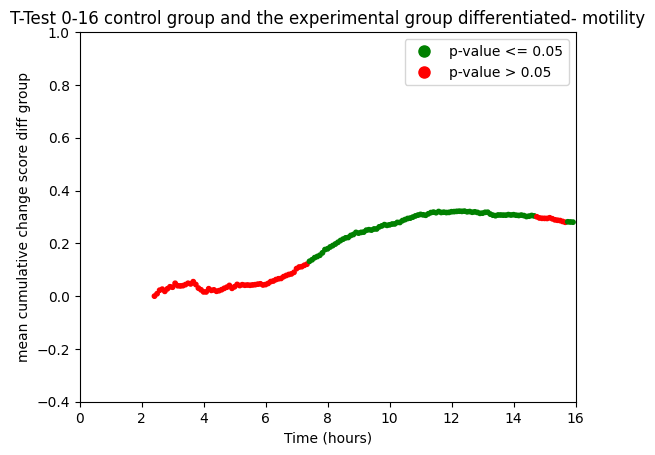

In [41]:
modality = 'motility'
df, all_p_value, significant_results = create_significant_results_cumulative_change(2,3,sign_level, modality)
p_value_df = preprocess_p_value_df(significant_results, 0, 192, df)
plot_t_test_results_cum_change(p_value_df, sign_level ,modality, 0, 16, 'Time (hours)', 'mean cumulative change score diff group', f'T-Test 0-16 control group and the experimental group differentiated- {modality}', to_save=to_save)

modality: intensity


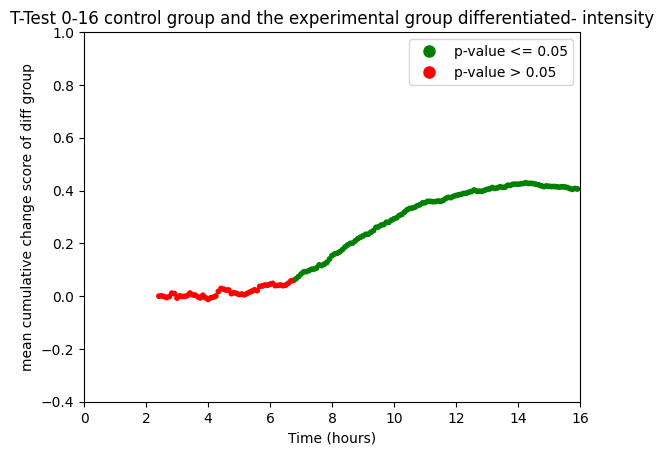

In [42]:
modality = 'intensity'

df, all_p_value, significant_results = create_significant_results_cumulative_change(2,3,sign_level, modality)
p_value_df = preprocess_p_value_df(significant_results, 0, 192, df)
plot_t_test_results_cum_change(p_value_df, sign_level ,modality, 0, 16, 'Time (hours)', 'mean cumulative change score of diff group', f'T-Test 0-16 control group and the experimental group differentiated- {modality}', to_save=to_save)

### T-test on the cumulative change P38i, ERKi+P38i ###

In [43]:
sign_level = 0.05
to_save=False

modality: intensity


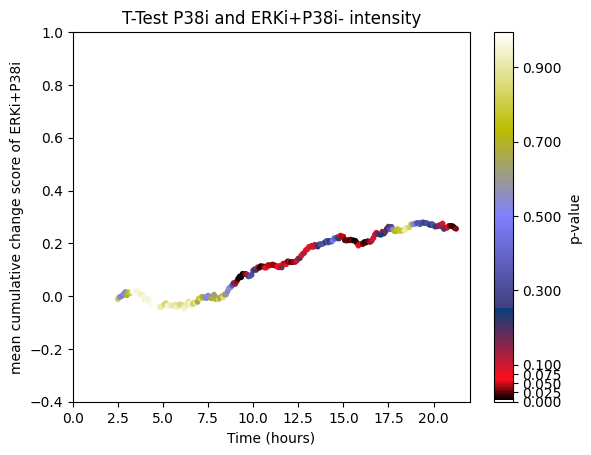

In [118]:
modality = 'intensity'
to_save=False
df, all_p_value, significant_results = create_significant_results_cumulative_change(8,6,sign_level, modality)
p_value_df = preprocess_p_value_df(significant_results, 0, 256, df)
plot_continuous_p_value_cum_change(all_p_value ,modality, 0, 22, 'Time (hours)', 'mean cumulative change score of ERKi+P38i', f'T-Test P38i and ERKi+P38i- {modality}', to_save=to_save)

modality: motility


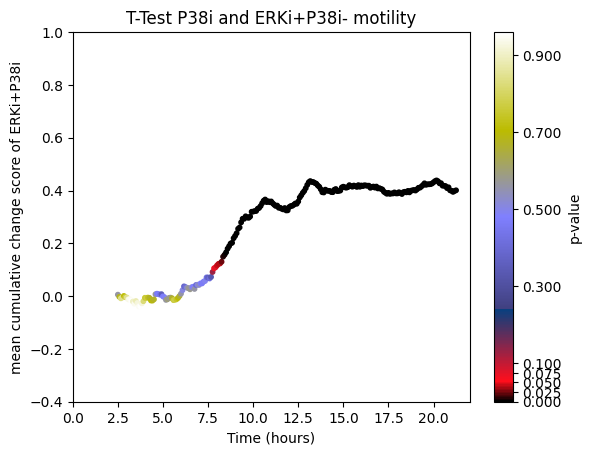

In [119]:
modality = 'motility'

df, all_p_value, significant_results = create_significant_results_cumulative_change(8,6,sign_level, modality)
p_value_df = preprocess_p_value_df(significant_results, 0, 256, df)
plot_continuous_p_value_cum_change(all_p_value ,modality, 0, 22, 'Time (hours)', 'mean cumulative change score of ERKi+P38i', f'T-Test P38i and ERKi+P38i- {modality}', to_save=to_save)

### T-test on the cumulative change ERKi, ERKi+P38i ###


modality: intensity


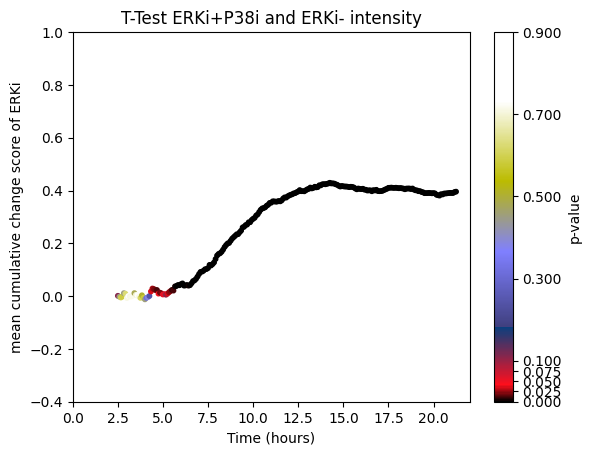

In [120]:
modality = 'intensity'

df, all_p_value, significant_results = create_significant_results_cumulative_change(6,3,sign_level, modality)
p_value_df = preprocess_p_value_df(significant_results, 0, 256, df)
plot_continuous_p_value_cum_change(all_p_value ,modality, 0, 22, 'Time (hours)', 'mean cumulative change score of ERKi', f'T-Test ERKi+P38i and ERKi- {modality}', to_save=to_save)

modality: motility


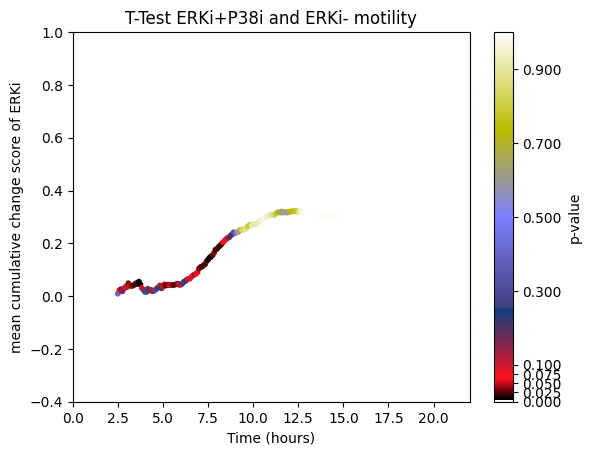

In [121]:
modality = 'motility'

df, all_p_value, significant_results = create_significant_results_cumulative_change(6,3,sign_level, modality)
p_value_df = preprocess_p_value_df(significant_results, 0, 256, df)
plot_continuous_p_value_cum_change(all_p_value ,modality, 0, 22, 'Time (hours)', 'mean cumulative change score of ERKi', f'T-Test ERKi+P38i and ERKi- {modality}', to_save=to_save)